## Import

In [1]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity

import pandas as pd
import numpy as np
import re

* load data

In [2]:
data_path = "C:\\Users\\PC\\OneDrive\\문서\\GitHub\\Korea_Investment_and_Securities\\datasets\\"

In [3]:
out_data_path = "C:\\Users\\PC\\OneDrive\\문서\\datasets\\"

In [4]:
sector_df = pd.read_csv(data_path + "sector_df.csv")
stock_01 = pd.read_csv(data_path + "stock_df_01.csv")
tot_df = pd.read_csv(data_path + "tot_df.csv", encoding = "cp949")

In [5]:
tot_df.head()

,Symbol,Name,Industry,IndustryCode
0,TSM,Taiwan Semiconductor Manufacturing Co Ltd ADR,반도체 및 반도체 장비,571010.0
1,V,Visa Inc Class A,소프트웨어 및 IT서비스,572010.0
2,JPM,JPMorgan Chase & Co,은행,551010.0
3,UNH,UnitedHealth Group Inc,헬스케어 업체 및 서비스,561020.0
4,JNJ,Johnson & Johnson,제약,562010.0


* make group df

In [6]:
'''
sector_df = pd.merge(sector_df, stock_01, on = "etf_names", how = "inner")

group_df = sector_df.groupby(["sector", "stock_names"])['etf_names'].count().reset_index()

for idx, sec in enumerate(group_df.sector.unique()):
    temp_df = group_df.loc[group_df.sector == secs]
    temp_df = temp_df.sort_values("etf_names", ascending = False)
    
    if idx == 0 :
        group_df_f = temp_df
    else :
        group_df_f = group_df_f.append(temp_df)

group_df_f.index = [x for x in range(group_df_f.shape[0])]
group_df['stock_names'] = [re.sub(",","",x) for x in group_df.stock_names]
group_df_f.to_csv(data_path + "group_df.csv", index = False)
'''

'\nsector_df = pd.merge(sector_df, stock_01, on = "etf_names", how = "inner")\n\ngroup_df = sector_df.groupby(["sector", "stock_names"])[\'etf_names\'].count().reset_index()\n\nfor idx, sec in enumerate(group_df.sector.unique()):\n    temp_df = group_df.loc[group_df.sector == secs]\n    temp_df = temp_df.sort_values("etf_names", ascending = False)\n    \n    if idx == 0 :\n        group_df_f = temp_df\n    else :\n        group_df_f = group_df_f.append(temp_df)\n\ngroup_df_f.index = [x for x in range(group_df_f.shape[0])]\ngroup_df[\'stock_names\'] = [re.sub(",","",x) for x in group_df.stock_names]\ngroup_df_f.to_csv(data_path + "group_df.csv", index = False)\n'

In [7]:
group_df = pd.read_csv(data_path + "group_df.csv")

* clustering per sector

In [8]:
def print_symbol(name, etf_name, tot_df):
    if name == 'U.S. Dollar':
        return '-'
    # 탐색 key value 선정
    temp_key_value = name.split(" ")
    key_value = temp_key_value[0]

    # TDM 구축
    total_name = []
    total_name.extend(etf_name)
    total_name.extend(list(tot_df.Name))

    tokenizer = CountVectorizer()
    tdm=tokenizer.fit_transform(total_name)

    first_select = [idx for idx, x in enumerate(total_name) if (x == name) or ((x.startswith(key_value)) and idx > len(etf_name))]

    if len(first_select) == 2:
        output_idx = first_select[1] - len(etf_name)
    elif len(first_select) == 1:
        return "-"
    else:
        sims = cosine_similarity(tdm[first_select[0]], tdm[first_select[1:]])
        output_idx = first_select[1:][np.argmax(sims)] - len(etf_name)

#    print("name: ", name,"\nresult:", tot_df.Name[output_idx])
    output = tot_df.iloc[output_idx].Symbol
    return output.split(".")[0]

In [9]:
etf_name = ["Berkshire Hathaway Inc. Class B",
"JPMorgan Chase & Co.", 
"Citigroup Inc.",
"Goldman Sachs Group, Inc."]

In [10]:
symbol = print_symbol(etf_name[3], etf_name, tot_df); symbol

'GS'

In [11]:
group_df.head(6)

,sector,stock_names,etf_names
0,Aerospace & Defense,AAR CORP.,3
1,Aerospace & Defense,HEICO Corporation,3
2,Aerospace & Defense,Northrop Grumman Corporation,3
3,Aerospace & Defense,Moog Inc. Class A,3
4,Aerospace & Defense,Mercury Systems Inc.,3
5,Aerospace & Defense,Maxar Technologies Inc.,3


* clustering

In [12]:
from tqdm import tqdm

In [13]:
symbol_dict = {}

In [ ]:
'''
# sector 별로 루프
#for sec in tqdm(group_df.sector.unique()):
for idx, sec in enumerate(group_df.sector.unique()):
    print(idx / group_df.sector.unique().shape[0])
    temp_df = group_df.loc[group_df.sector == sec,:]
    
    # symbol check, 오래걸림
    sec_symbols = []
    for stock in tqdm(temp_df.stock_names):
        symbol = print_symbol(stock, temp_df.stock_names, tot_df)
        if symbol == "-":
            continue
        
        sec_symbols.append(symbol)
    
    symbol_dict[sec] = sec_symbols    
'''

In [14]:
import pickle

In [19]:
'''
with open(out_data_path + 'symbol_dict.pickle', 'wb') as f:
    pickle.dump(symbol_dict, f, pickle.HIGHEST_PROTOCOL)
'''

In [15]:
with open(out_data_path + "symbol_dict.pickle", "rb") as f:
    symbol_dict = pickle.load(f)

* imputation

In [16]:
from sklearn.impute import KNNImputer

In [17]:
stock_02 = pd.read_csv(out_data_path + "stock_df_02.csv")

'''
select_col = [x for x in stock_02.columns if "_" not in x]
select_col.extend([x for x in stock_02.columns if ("_x" in x) and (".") not in x])
stock_02 = stock_02.loc[:, select_col]
col_names = [x for x in stock_02.columns if "_" not in x]
col_names.extend([x.split("_")[0] for x in stock_02.columns if "_" in x])
stock_02.columns = col_names
stock_02.to_csv(out_data_path + "stock_df_02.csv", index = False)
'''

'\nselect_col = [x for x in stock_02.columns if "_" not in x]\nselect_col.extend([x for x in stock_02.columns if ("_x" in x) and (".") not in x])\nstock_02 = stock_02.loc[:, select_col]\ncol_names = [x for x in stock_02.columns if "_" not in x]\ncol_names.extend([x.split("_")[0] for x in stock_02.columns if "_" in x])\nstock_02.columns = col_names\nstock_02.to_csv(out_data_path + "stock_df_02.csv", index = False)\n'

In [18]:
half_nan  = np.where(stock_02.isnull().sum(axis = 0) <= stock_02.shape[0] * 0.45)[0]

In [19]:
stock_02 = stock_02.iloc[:, half_nan]

In [20]:
imputer = KNNImputer(n_neighbors=5)

In [21]:
imputed_x = imputer.fit_transform(np.array(stock_02.iloc[:, 1:]))

In [22]:
imputed_x.shape

(1831, 4520)

* scaling

In [23]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [24]:
#scaler = StandardScaler()
scaler = MinMaxScaler()

In [25]:
scaled_x= scaler.fit_transform(imputed_x)

In [26]:
scaled_x.shape

(1831, 4520)

In [27]:
stock_02.loc[:, "TSM":] = scaled_x
# stock_02.iloc[:, 1:] = scaled_x

In [28]:
stock_02.head()

,Date,TSM,V,JPM,UNH,JNJ,BAC,WMT,PG,HD,...,EBR,HEI,CWEN,CIG,GTN,GEF,AGM,HVT,BH,XXII
0,2014-12-31,0.029696,0.020915,0.080111,0.005336,0.155961,0.176086,0.305697,0.239522,0.012753,...,0.096805,0.051580,0.448639,0.926887,0.215445,0.494887,0.069318,0.286942,0.805844,0.215415
1,2015-01-02,0.028876,0.024638,0.079353,0.004574,0.155398,0.176347,0.305904,0.232761,0.007867,...,0.096805,0.043023,0.229763,0.919811,0.200336,0.499148,0.058042,0.287419,0.813736,0.235178
2,2015-01-05,0.024446,0.016914,0.063011,0.000492,0.147171,0.162742,0.303310,0.228289,0.000983,...,0.087125,0.041104,0.463768,0.860849,0.191382,0.464210,0.052972,0.296491,0.820117,0.217391
3,2015-01-06,0.021329,0.014709,0.049785,0.000000,0.141424,0.149137,0.310159,0.224025,0.000000,...,0.082285,0.039944,0.284058,0.834906,0.160045,0.440349,0.045629,0.285987,0.795382,0.201581
4,2015-01-07,0.023872,0.019264,0.050543,0.002484,0.167117,0.151230,0.333921,0.228913,0.010976,...,0.098742,0.041744,0.192365,0.858490,0.160604,0.449084,0.045105,0.285987,0.826408,0.195652


In [27]:
stock_02.shape

(1831, 4521)

In [28]:
#stock_02.to_csv(out_data_path + "scaled_stocks.csv", index = False)
#stock_02.to_csv(out_data_path + "mm_scaled_stocks.csv", index = False)

* clustering

In [29]:
from tslearn.clustering import TimeSeriesKMeans

import matplotlib.pyplot as plt

In [30]:
stock_02 = pd.read_csv(out_data_path + "scaled_stocks.csv")

In [31]:
temp_stock = stock_02.loc[stock_02.Date >= "2017-01-01",:]

In [32]:
sym_name = list(symbol_dict.keys())[0]; sym_name

'Aerospace & Defense'

In [33]:
symbols = symbol_dict[sym_name]
symbols = [x.split(".")[0] for x in symbols]

In [34]:
#cluster_input = np.expand_dims(np.array(stock_02.loc[:, stock_02.columns.isin(symbols)].T), 2)
cluster_input = np.expand_dims(np.array(temp_stock.loc[:, temp_stock.columns.isin(symbols)].T), 2)

In [35]:
n_cluster_dict = {}

In [36]:
temp_stock.loc[:, temp_stock.columns.isin(symbols)].columns

Index(['RTX', 'BA', 'LMT', 'NOC', 'GD', 'TDG', 'KEYS', 'BLL', 'TDY', 'J',
       'TXT', 'HWM', 'LDOS', 'BAH', 'CAE', 'OSK', 'HII', 'KBR', 'CACI', 'CW',
       'SPR', 'SAIC', 'HXL', 'BWXT', 'AJRD', 'ATI', 'SPCE', 'MAXR', 'AIR',
       'TGI', 'RGR', 'KAMN', 'NPK', 'DCO', 'VEC', 'HON', 'AXON', 'ESLT', 'WWD',
       'ROLL', 'IRDM', 'MNDT', 'MANT', 'VSAT', 'MRCY', 'KTOS', 'AVAV', 'OSIS',
       'SWBI', 'RADA', 'CMTL', 'HEI'],
      dtype='object')

In [38]:
tot_df.Symbol = [x.split(".")[0] if "." in x else x for x in tot_df.Symbol]

* select best number of cluster

In [187]:
'''
select_n_dict = {}

## symbol loop
for sym_name in symbol_dict.keys():
    symbols = symbol_dict[sym_name]
    symbols = [x.split(".")[0] for x in symbols]
    cluster_input = np.expand_dims(np.array(temp_stock.loc[:, temp_stock.columns.isin(symbols)].T), 2)
    max_iter = np.min([cluster_input.shape[0], 15])
    
    ## cluster loop
    temp_dict = {}
    for n_ in range(3, max_iter):
        model = TimeSeriesKMeans(n_clusters=n_, random_state=0, n_jobs = -1,verbose = True)
        y_pred = model.fit_predict(cluster_input)
        score = silhouette_score(cluster_input.reshape(cluster_input.shape[0], cluster_input.shape[1]), y_pred)
        temp_dict[str(n_)] = score
    
    select_n_dict[sym_name] = temp_dict
'''

In [162]:
'''
with open(data_path + "cluster_dict.pickle", "wb") as f:
    pickle.dump(select_n_dict, f, pickle.HIGHEST_PROTOCOL)
'''

In [39]:
with open(data_path + "cluster_dict.pickle", "rb") as f:
    select_n_dict = pickle.load(f)

In [41]:
'''
keys = []
n_s = []
scores = []

for syms in select_n_dict.keys():
    try:
        max_idx = np.argmax(list(select_n_dict[syms].values()))
        max_n = list(select_n_dict[syms].keys())[max_idx]
        max_score = select_n_dict[syms][max_n]

        keys.append(syms)
        n_s.append(max_n)
        scores.append(max_score)
    except:
        continue
    

max_cluster_df = pㄴd.DataFrame({"sector":keys, "cluster_n": n_s, "score": scores})
#max_cluster_df.to_csv(data_path + "max_cluster_df_03.csv", index = False)
'''

* clustering

In [44]:
max_cluster_df = pd.read_csv(data_path + "max_cluster_df_03.csv")

In [52]:
max_cluster_df

,sector,cluster_n,score
0,Aerospace & Defense,3,0.297947
1,Artificial Intelligence,3,0.277618
2,Bank,3,0.245222
3,Broad Maturities,3,0.250095
4,Communications Equipment,3,0.250435
5,Construction & Engineering,3,0.351666
6,Consumer,3,0.241948
7,Consumer Discretionary,3,0.241948
8,Environment,3,0.193252
9,Financials,3,0.253982


In [45]:
symbols = symbol_dict[sym_name]
symbols = [x.split(".")[0] for x in symbols]
cluster_input = np.expand_dims(np.array(temp_stock.loc[:, temp_stock.columns.isin(symbols)].T), 2)

best_n = int(max_cluster_df.loc[max_cluster_df.sector == syms].cluster_n.values[0])
#model = TimeSeriesKMeans(n_clusters=best_n, metric="softdtw", random_state=0, n_jobs = -1,verbose = True)

model = TimeSeriesKMeans(n_clusters=best_n, random_state=0, n_jobs = -1,verbose = True)
y_pred = model.fit_predict(cluster_input)

802.855 --> 448.686 --> 421.168 --> 411.680 --> 411.680 --> 


In [46]:
sz = cluster_input.shape[1]

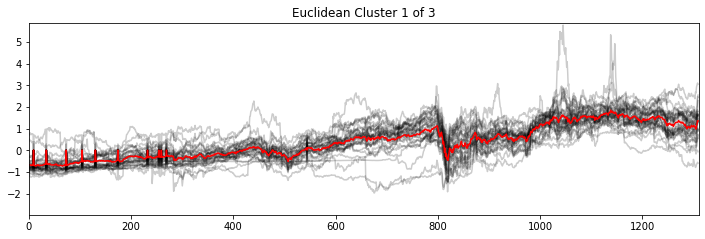

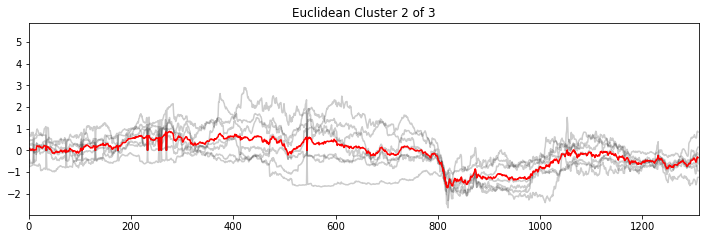

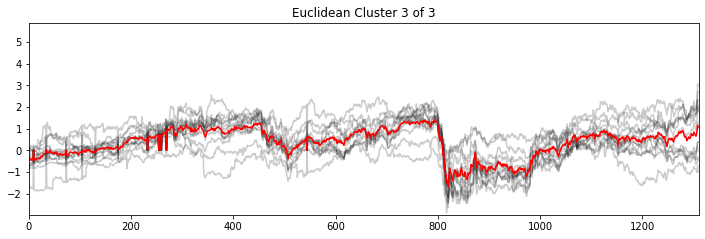

In [53]:
for yi in range(best_n):
    plt.figure(figsize = (12,12))
    plt.subplot(best_n, 1, yi + 1)
    for xx in cluster_input[y_pred == yi]:
        plt.plot(xx.ravel(), "k-", alpha=.2)
    plt.plot(model.cluster_centers_[yi].ravel(), "r-")
    plt.xlim(0, sz)
    plt.ylim(np.min(cluster_input)-0.1, np.max(cluster_input) + 0.1)
    plt.title("Euclidean Cluster {n} of {m}".format(n = yi+1, m = best_n))
    
    #if yi == 1:
    #    plt.title("Soft-DTW $k$-means")
    #plt.savefig('fig1.png', dpi=300)

In [ ]:
for sym_name in symbol_dict.keys():
    symbols = symbol_dict[sym_name]
    symbols = [x.split(".")[0] for x in symbols]
    cluster_input = np.expand_dims(np.array(temp_stock.loc[:, temp_stock.columns.isin(symbols)].T), 2)
    
    best_n = int(max_cluster_df.loc[max_cluster_df.sector == syms].cluster_n.values[0])
    #model = TimeSeriesKMeans(n_clusters=best_n, metric="softdtw", random_state=0, n_jobs = -1,verbose = True)
    model = TimeSeriesKMeans(n_clusters=best_n, random_state=0, n_jobs = -1,verbose = True)
    y_pred = model.fit_predict(cluster_input)

In [ ]:
for syms in select_n_dict.keys():
    best_n = int(max_cluster_df.loc[max_cluster_df.sector == syms].cluster_n.values[0])
    #model = TimeSeriesKMeans(n_clusters=best_n, metric="softdtw", random_state=0, n_jobs = -1,verbose = True)
    model = TimeSeriesKMeans(n_clusters=best_n, random_state=0, n_jobs = -1,verbose = True)
    y_pred = model.fit_predict(cluster_input)

In [105]:
n_ = 3

In [106]:
#model = TimeSeriesKMeans(n_clusters=n_, metric="softdtw", random_state=0, n_jobs = -1,verbose = True)
model = TimeSeriesKMeans(n_clusters=n_, random_state=0, n_jobs = -1,verbose = True)
y_pred = model.fit_predict(cluster_input)

802.855 --> 448.686 --> 421.168 --> 411.680 --> 411.680 --> 


In [109]:
sz = cluster_input.shape[1]

IndexError: index 3 is out of bounds for axis 0 with size 3

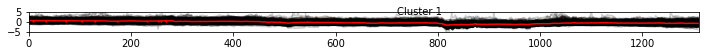

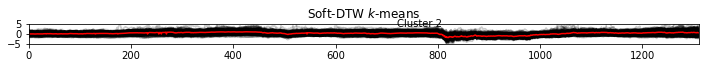

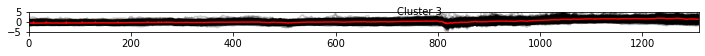

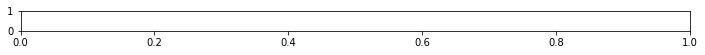

In [199]:
for yi in range(n_):
    plt.figure(figsize = (12,6))
    plt.subplot(n_, 1, yi + 1)
    for xx in cluster_input[y_pred == yi]:
        plt.plot(xx.ravel(), "k-", alpha=.2)
    plt.plot(model.cluster_centers_[yi].ravel(), "r-")
    plt.xlim(0, sz)
    plt.ylim(-5, 5)
    plt.text(0.55, 0.85,'Cluster %d' % (yi + 1),
             transform=plt.gca().transAxes)
    if yi == 1:
        plt.title("Soft-DTW $k$-means")

In [111]:
from sklearn.metrics import silhouette_score

score = silhouette_score(cluster_input.reshape(cluster_input.shape[0], cluster_input.shape[1]), y_pred)
print("Silhouette Score: %.4f" % score)

Silhouette Score: 0.2979


In [112]:
score

0.2979468606251709